Número total de archivos de imagen: 282
sequence_length: 100, future_steps: 6
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100, 1024)         37752832  
                                                                 
 dropout_10 (Dropout)        (None, 100, 1024)         0         
                                                                 
 lstm_11 (LSTM)              (None, 512)               3147776   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 294912)            151289856 
                                                                 
 reshape_5 (Reshape)         (None, 6, 128, 128, 3)    0         
                                          

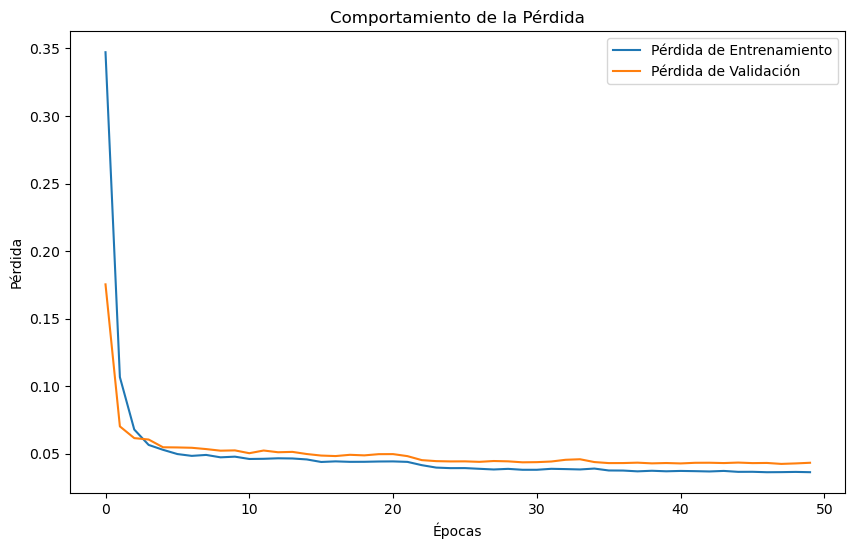

6/6 [==============================] - 5s 661ms/step
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101171020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101172020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101173020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101174020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101175020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101180020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101172020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101173020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101174020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101175020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_s20230101180020_pred.png
Guardada imagen: ../data/Img_test/OR_ABI-L2-ACMF-M6_G16_

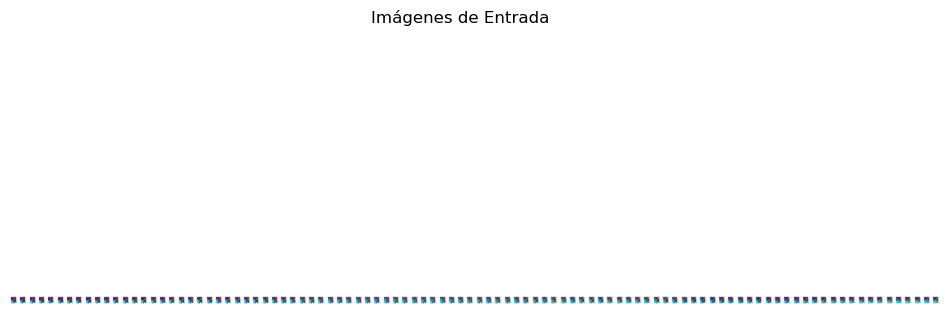

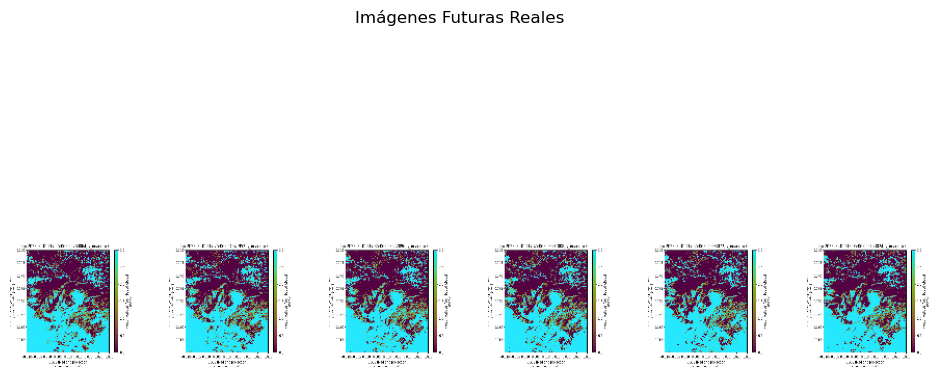

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


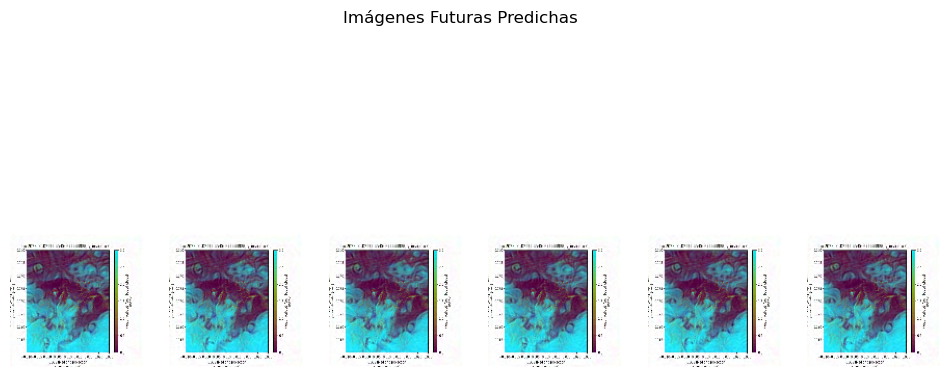

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Parámetros
image_folder = '../data/Img_test/'
future_steps = 6
height, width, channels = 128, 128, 3  # Resolución aumentada
sequence_length = 100

# Verifica el número de imágenes disponibles
image_files = sorted([f for f in os.listdir(image_folder) if f.startswith('OR_ABI-L2')])
if len(image_files) < sequence_length + future_steps:
    raise ValueError("No hay suficientes imágenes para formar secuencias.")

print(f"Número total de archivos de imagen: {len(image_files)}")
print(f"sequence_length: {sequence_length}, future_steps: {future_steps}")

# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(image_path, target_size=(height, width)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalizar
    return image

# Función para cargar secuencias de imágenes
def load_image_sequences(folder, sequence_length, future_steps):
    X, y = [], []
    image_files = sorted([f for f in os.listdir(folder) if f.startswith('OR_ABI-L2')])
    for i in range(0, len(image_files) - sequence_length - future_steps + 1):
        sequence_images = []
        future_images = []

        for j in range(sequence_length):
            image_path = os.path.join(folder, image_files[i + j])
            sequence_images.append(load_and_preprocess_image(image_path))

        for k in range(sequence_length, sequence_length + future_steps):
            image_path = os.path.join(folder, image_files[i + k])
            future_images.append(load_and_preprocess_image(image_path))

        X.append(sequence_images)
        y.append(future_images)

    return np.array(X), np.array(y)

# Cargar las secuencias de imágenes
X, y = load_image_sequences(image_folder, sequence_length, future_steps)

# Modelo VGG16 para extraer características
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
flatten_layer = Flatten()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=flatten_layer)
feature_extractor.trainable = False  # Congelar los pesos

# Función para extraer características de secuencias de imágenes
def extract_features(image_sequences):
    num_sequences = image_sequences.shape[0]
    features = np.zeros((num_sequences, sequence_length, feature_extractor.output_shape[1]))
    for i in range(num_sequences):
        for j in range(sequence_length):
            image = image_sequences[i, j]
            image = np.expand_dims(image, axis=0)  # Añadir dimensión del lote
            feature = feature_extractor.predict(image, verbose=0)
            features[i, j] = feature.squeeze()
    return features

# Extraer características
X_features = extract_features(X)

# Modelo VGG para la pérdida perceptual
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
vgg.trainable = False
feature_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)

# Función de pérdida mixta (MSE + perceptual)
def mixed_loss(y_true, y_pred):
    perceptual = 0
    for i in range(future_steps):  # Iterar sobre los pasos futuros
        y_true_features = feature_model(y_true[:, i])  # Extraer características para cada paso
        y_pred_features = feature_model(y_pred[:, i])
        perceptual += tf.reduce_mean(tf.square(y_true_features - y_pred_features))
    perceptual /= future_steps
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss + 0.1 * perceptual  # Ponderación de pérdidas

# Construcción del modelo LSTM
model = Sequential()
model.add(LSTM(1024, input_shape=(sequence_length, feature_extractor.output_shape[1]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(future_steps * height * width * channels, activation='linear'))
model.add(Reshape((future_steps, height, width, channels)))

model.compile(optimizer='adam', loss=mixed_loss)
model.summary()

# Configuración del callback para ajustar la tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenamiento del modelo
history = model.fit(X_features, y, epochs=50, batch_size=16, validation_split=0.2, callbacks=[reduce_lr])

# Función para graficar la pérdida de entrenamiento y validación
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Comportamiento de la Pérdida')
    plt.legend()
    plt.show()

# Graficar la pérdida
plot_loss(history)

# Realizar predicciones
y_pred = model.predict(X_features)

# Guardar imágenes futuras predichas
def save_images(images, folder, original_filenames, suffix='_pred'):
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            image = images[i, j]
            base, ext = os.path.splitext(original_filenames[i + sequence_length + j])
            new_filename = f"{base}{suffix}{ext}"
            new_filepath = os.path.join(folder, new_filename)
            image = (image * 255).astype('uint8')  # Desnormalizar
            cv2.imwrite(new_filepath, image)
            print(f"Guardada imagen: {new_filepath}")

save_images(y_pred, image_folder, image_files)

# Visualización de imágenes reales, predichas y futuras
def mostrar_imagenes(imagenes, titulo):
    plt.figure(figsize=(12, 6))
    for i in range(imagenes.shape[0]):
        plt.subplot(1, imagenes.shape[0], i + 1)
        plt.imshow(imagenes[i])
        plt.axis('off')
    plt.suptitle(titulo)
    plt.show()

# Visualizar las imágenes
indice_secuencia = 0
mostrar_imagenes(X[indice_secuencia], 'Imágenes de Entrada')
mostrar_imagenes(y[indice_secuencia], 'Imágenes Futuras Reales')
mostrar_imagenes(y_pred[indice_secuencia], 'Imágenes Futuras Predichas')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


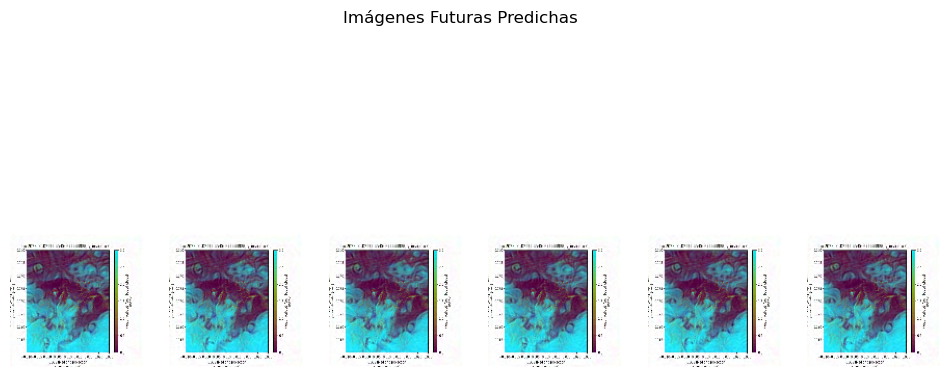

In [13]:
mostrar_imagenes(y_pred[0], 'Imágenes Futuras Predichas')


In [14]:
model.save('Test2.h5')

/Users/santiagoromero/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
